<a href="https://colab.research.google.com/github/poisonkissedsk/Production-Grade-AI-QA-Suite/blob/main/Continuous_Monitoring_%26_Drift_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1-4279064273.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric] = StandardScaler().fit_transform(X[numeric])
/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)



Processing Batch 1/19
age: KS Drift Score = 0.2360
fnlwgt: KS Drift Score = 0.7246
education-num: KS Drift Score = 0.0073
capital-gain: KS Drift Score = 0.0000
capital-loss: KS Drift Score = 0.0000
hours-per-week: KS Drift Score = 0.0001
Prediction Output Drift: 0.0031

Processing Batch 2/19
age: KS Drift Score = 0.7703
fnlwgt: KS Drift Score = 0.9139
education-num: KS Drift Score = 0.0712
capital-gain: KS Drift Score = 0.0000
capital-loss: KS Drift Score = 0.0000
hours-per-week: KS Drift Score = 0.0002
Prediction Output Drift: 0.0053

Processing Batch 3/19
age: KS Drift Score = 0.2847
fnlwgt: KS Drift Score = 0.8135
education-num: KS Drift Score = 0.2172
capital-gain: KS Drift Score = 0.0170
capital-loss: KS Drift Score = 0.0000
hours-per-week: KS Drift Score = 0.1122
Prediction Output Drift: 0.0009

Processing Batch 4/19
age: KS Drift Score = 0.1168
fnlwgt: KS Drift Score = 0.4772
education-num: KS Drift Score = 0.5361
capital-gain: KS Drift Score = 0.0093
capital-loss: KS Drift Sco

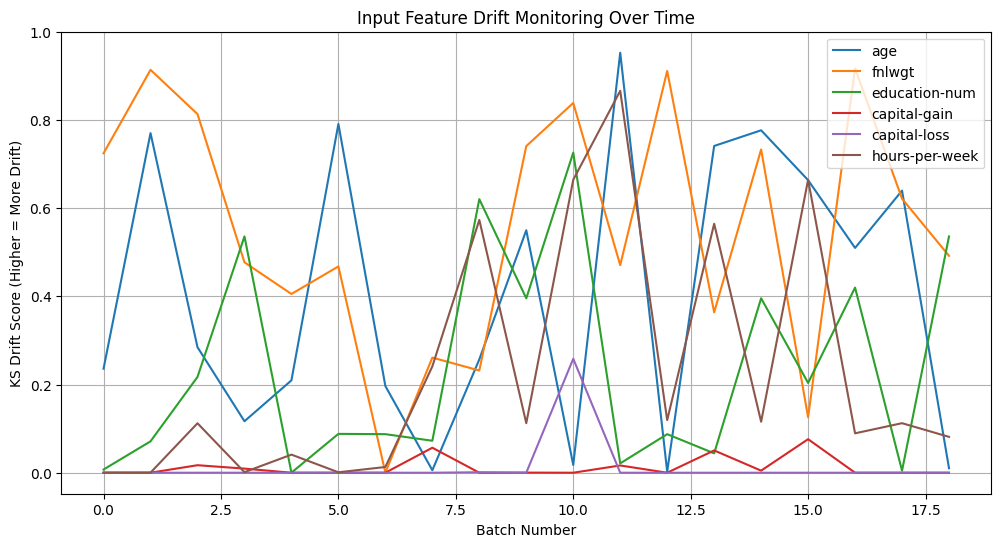

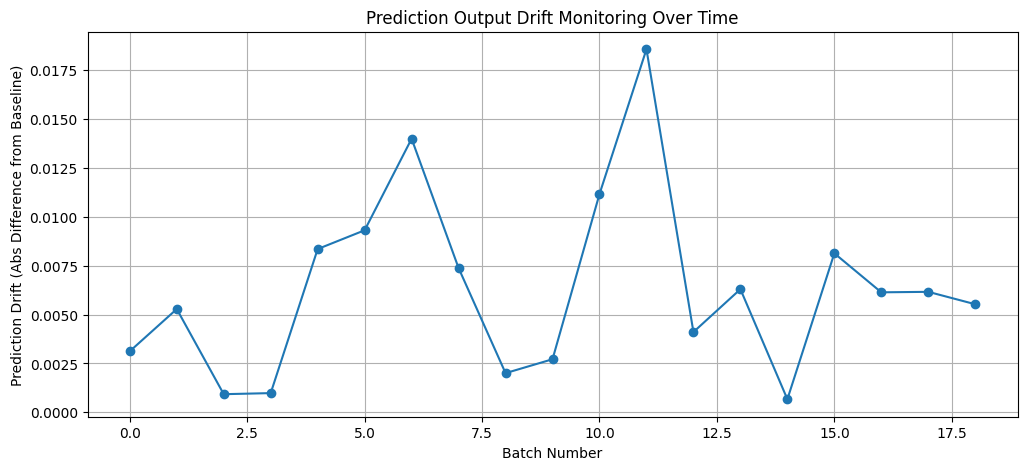

In [1]:
# 📒 Notebook 5: Continuous Monitoring & Drift Detection (Google Colab)

# -- SETUP --
!pip install scikit-learn pandas numpy matplotlib seaborn scipy --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# -- STEP 1: Load and Prepare Baseline Training Data --

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

df = pd.read_csv(url, names=columns, na_values=' ?', skipinitialspace=True)
df.dropna(inplace=True)
df['label'] = (df['income'] == '>50K').astype(int)

categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

for col in categorical:
    df[col] = LabelEncoder().fit_transform(df[col])

X = df[categorical + numeric]
y = df['label']

X[numeric] = StandardScaler().fit_transform(X[numeric])

X_train, X_monitor, y_train, y_monitor = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# -- STEP 2: Train Baseline Model --

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# -- STEP 3: Simulate Incoming Data Batches for Monitoring --

batch_size = 500
num_batches = int(len(X_monitor) / batch_size)
batches = np.array_split(X_monitor, num_batches)

# -- STEP 4: Initialize Drift Monitoring Logs --

ks_drift_log = {feature: [] for feature in numeric}
output_drift_log = []

baseline_preds = model.predict_proba(X_train)[:, 1]
baseline_mean = baseline_preds.mean()

# -- STEP 5: Process Incoming Batches and Monitor Drift --

for batch_idx, batch in enumerate(batches):
    print(f"\nProcessing Batch {batch_idx+1}/{num_batches}")

    # Input Feature Drift - KS Test vs Baseline Training Data
    for feature in numeric:
        stat, p_value = ks_2samp(X_train[feature], batch[feature])
        ks_drift_log[feature].append(1 - p_value)  # Higher = more drift
        print(f"{feature}: KS Drift Score = {1 - p_value:.4f}")

    # Prediction Drift Monitoring
    batch_preds = model.predict_proba(batch)[:, 1]
    batch_mean = batch_preds.mean()
    output_drift_log.append(abs(batch_mean - baseline_mean))
    print(f"Prediction Output Drift: {abs(batch_mean - baseline_mean):.4f}")

# -- STEP 6: Visualize Input Drift Over Time --

plt.figure(figsize=(12,6))
for feature in numeric:
    plt.plot(ks_drift_log[feature], label=feature)

plt.xlabel('Batch Number')
plt.ylabel('KS Drift Score (Higher = More Drift)')
plt.title('Input Feature Drift Monitoring Over Time')
plt.legend()
plt.grid()
plt.show()

# -- STEP 7: Visualize Prediction Drift Over Time --

plt.figure(figsize=(12,5))
plt.plot(output_drift_log, marker='o')
plt.xlabel('Batch Number')
plt.ylabel('Prediction Drift (Abs Difference from Baseline)')
plt.title('Prediction Output Drift Monitoring Over Time')
plt.grid()
plt.show()
